In [1]:
## imports
import matplotlib.pyplot as plt
from src.utils.plot_utils import *
from src.utils.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath
import h5py

Using diffeqsolve-based neural simulation (original)


In [2]:
## plotting defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 1.5

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

dataPath = "/data/users/smpuglie/Pugliese_2025/"

## MANC 1024x DNg100 activation

In [4]:
simType = "DNg100_Stim"
simPath = simType+"/hyak/run_id=28123286"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

KeyboardInterrupt: 

In [ ]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
nMnsActivePastTransient = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    # active neurons
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
    nMnsActivePastTransient.loc[i] = np.sum(activeMnsMaskPastTransient)
    simScore.loc[i] = score

figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


### individual traces

791


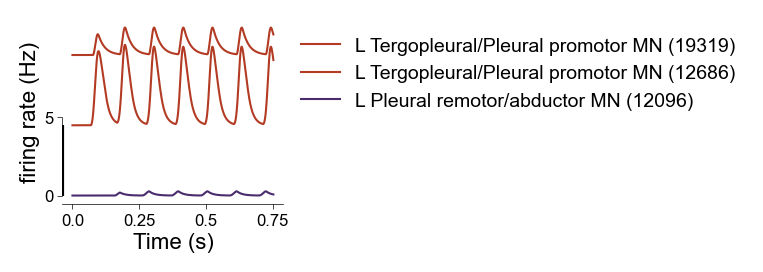

In [ ]:
idx = np.random.randint(1000) 
spacer = 4.5
width = 3

R = Rs[idx]

plt.figure()
print(idx)
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer)# ,colorMapper=colorMapper)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,5,"k",linewidth=0.25)
plt.yticks([0,5])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.tick_params(labelsize=6)
# ax.grid(axis="x",color="lightgrey",linestyle="--")
ax.grid(False)
plt.ylabel("firing rate (Hz)",fontsize=8)
# plt.xlabel("Time (s)",fontsize=8)
fig = plt.gcf()
# fig.set_figheight(0.5*len(get_active_data(R[mnData.index],mnData)))
# fig.set_figheight(2.5)
# fig.set_figwidth(width)

fig.set_figwidth(1.426)
fig.set_figheight(1.2)




plt.show()

530,819,854,**694**,**674**, 813 unrepresentative but interesting

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


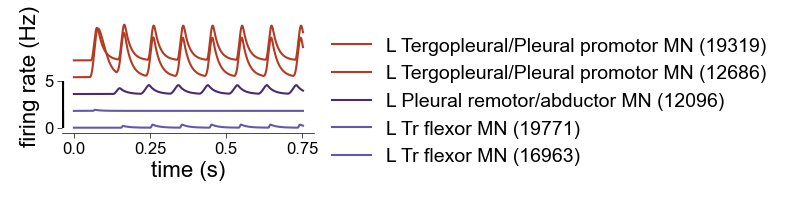

In [ ]:
idx = 694 #np.random.randint(nSims)
spacer = 3*3/5
scalebar = 5

timeLimit = .75

R = Rs[idx]

mnsToPlot = sort_motor_modules(wTable.loc[wTable["bodyId"].isin(mnIdsToPlot)])

plt.figure()
# ax = plot_R_traces_stacked_by_module(R[:,:int(timeLimit/params.sim.dt)],mnsToPlot,activeOnly=False,space=spacer)
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer)# ,colorMapper=colorMapper)
add_tAxis(ax,timeLimit,3.00001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
fig.set_figheight(0.15*len(get_active_data(R[mnsToPlot.index],mnsToPlot)))
ax.grid(False)
plt.xlabel("time (s)")


fig.set_figwidth(1.626)
fig.set_figheight(1.226*3/5)
# fig.set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnTraces_idx{idx}.svg",transparent=True)
plt.show()

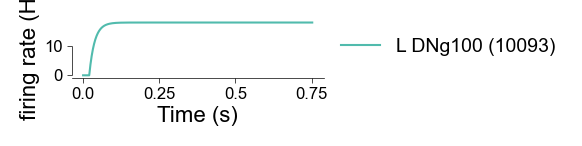

In [ ]:
idx = 694 # np.random.randint(1000)
R = Rs[idx]
spacer=10

tIdxs = np.arange(0,1000)

dng100data = wTable.loc[[31,132]].copy()
dng100data["somaSide"] = ["LHS","RHS"]

plt.figure()
ax = plot_R_traces_stacked_2(R[:,:750],dng100data,activeOnly=True,space=spacer,colors=["#51bbad"])# ,colorMapper=colorMapper)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,10,"k",linewidth=0.25)
plt.yticks([0,10])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.grid(False)
plt.ylabel("firing rate (Hz)")
fig = plt.gcf()

fig.set_figwidth(1.626)
fig.set_figheight(0.377)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/dng100trace_idx{idx}.svg",transparent=True)
plt.show()

### overall data

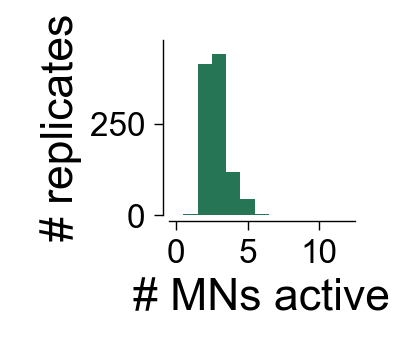

In [ ]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

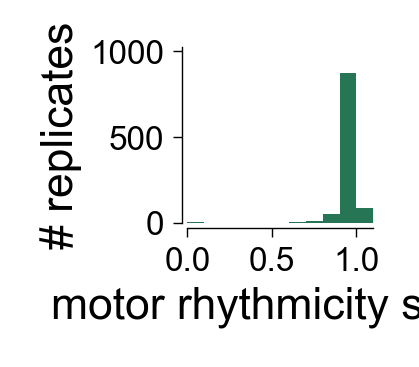

In [ ]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

## FANC 1024x DNg100 activation

In [ ]:
simType = "DNg100_Stim_FANC"
simPath = simType+"/walle-smpuglie/run_id=walle"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/.hydra/config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 803, 2001)

In [ ]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
nMnsActivePastTransient = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    # active neurons
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
    nMnsActivePastTransient.loc[i] = np.sum(activeMnsMaskPastTransient)
    simScore.loc[i] = score

figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


### individual traces

99
0.9796184301376343


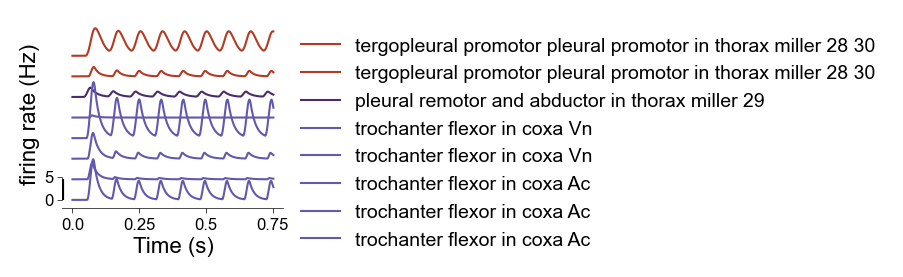

In [ ]:
idx = np.random.randint(1000) 
spacer = 4.5
width = 3

R = Rs[idx]

plt.figure()
print(idx)
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer,fanc=True)# ,colorMapper=colorMapper)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,5,"k",linewidth=0.25)
plt.yticks([0,5])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.tick_params(labelsize=6)
# ax.grid(axis="x",color="lightgrey",linestyle="--")
ax.grid(False)
plt.ylabel("firing rate (Hz)",fontsize=8)
# plt.xlabel("Time (s)",fontsize=8)
fig = plt.gcf()
# fig.set_figheight(0.5*len(get_active_data(R[mnData.index],mnData)))
# fig.set_figheight(2.5)
# fig.set_figwidth(width)

fig.set_figwidth(1.426)
fig.set_figheight(1.226)

print(simScore[idx])
plt.show()

761, 99

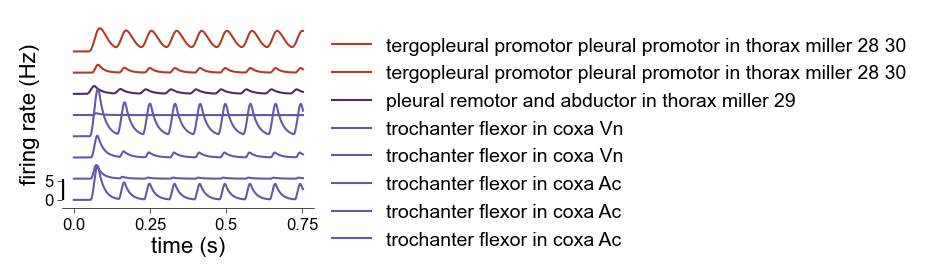

In [ ]:
idx = 99 #np.random.randint(nSims)
spacer = 5.5
scalebar = 5

timeLimit = .75

R = Rs[idx]

plt.figure()
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer,fanc=True)# ,colorMapper=colorMapper)
add_tAxis(ax,timeLimit,3.00001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
ax.grid(False)
plt.xlabel("time (s)")


fig.set_figwidth(1.626)
fig.set_figheight(1.226)
# fig.set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnTraces_idx{idx}.svg",transparent=True)
plt.show()

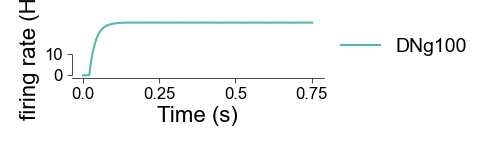

In [ ]:
idx = 99 # np.random.randint(1000)
R = Rs[idx]
spacer=10

tIdxs = np.arange(0,1000)

dng100data = wTable.loc[[0]].copy()

plt.figure()
ax = plot_R_traces_stacked_2(R[:,:750],dng100data,activeOnly=True,space=spacer,colors=["#51bbad"],fanc=True)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,10,"k",linewidth=0.25)
plt.yticks([0,10])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.grid(False)
plt.ylabel("firing rate (Hz)")
fig = plt.gcf()

fig.set_figwidth(1.626)
fig.set_figheight(0.377)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/dng100trace_idx{idx}.svg",transparent=True)
plt.show()

### overall data

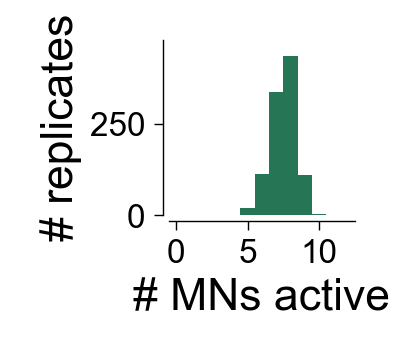

In [ ]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(nMnsActive,color=mnColor,edgecolor="none",binwidth=1,kde=False,alpha=1,discrete=True)

plt.ylim([0,480])
plt.xlim([-0.5,12.5])
plt.xticks([0,5,10],labels=[0,5,10])
plt.ylabel("# replicates",fontsize=8)
plt.xlabel("# MNs active",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)
sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/activeMnHist.svg",transparent=True)
plt.show()

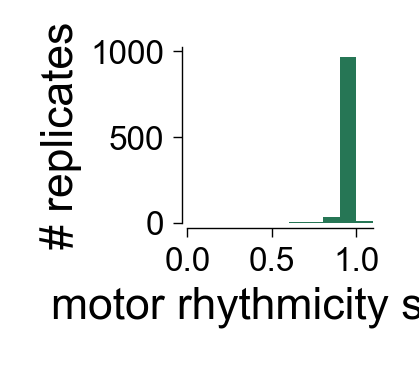

In [ ]:
plt.figure(figsize=(0.600,0.57))

ax = sns.histplot(simScore,color=mnColor,edgecolor="none",bins=np.arange(0,1.5,0.1),kde=False,alpha=1.0)
plt.xlim([0,1.1])
plt.ylim([0,1024])
plt.yticks([0,500,1000])
plt.xticks(np.arange(0,1.1,0.5))
plt.xlabel("motor rhythmicity score",fontsize=8)
plt.ylabel("# replicates",fontsize=8)
plt.gca().tick_params(axis='both', which='major', labelsize=6)
plt.gcf().set_dpi(400)

sns.despine(offset=1)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/mnScoreHist.svg",transparent=True)
plt.show()

## MANC DNg100 activation $w_{ij}$ noise $\sigma$ sweep

In [3]:
simType = "DNg100_Stim"
simPath = simType+"/hyak/run_id=28990713"
folder = dataPath + simPath
overallParams = DictConfig(load_from_yaml(folder+"/multirun.yaml"))
wTable = pd.read_csv("../"+overallParams.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nSims = overallParams.experiment.n_replicates

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [4]:
# nActive = pd.DataFrame(index=np.arange(nSims))
# nMnsActive = pd.DataFrame(index=np.arange(nSims))
# simScore = pd.DataFrame(index=np.arange(nSims))
# mnFreq = pd.DataFrame(index=np.arange(nSims))

# subfolders = []
# for f in os.listdir(folder):
#     if os.path.isdir(f"{folder}/{f}"):
#         subfolders.append(f)

# for subfolder in subfolders:
#     print(f"Loading {subfolder}")
#     Rs = sparse.load_npz(folder+f"/{subfolder}/ckpt/{simType}_Rs.npz").todense()
#     dataset = 0
#     Rs = Rs[dataset]
#     params = DictConfig(load_from_yaml(folder+f"/{subfolder}/.hydra/config.yaml"))
#     noiseStd = params.sim.noiseStdvProp
#     for i in range(nSims):
#         # active neurons
#         R = Rs[i]
#         nActive.loc[i,noiseStd] = sum(np.max(R,1)>0.01)
#         activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
#         nMnsActive.loc[i,noiseStd] = np.sum(activeMnsMask)
#         activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
#         score, freq = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
#         simScore.loc[i,noiseStd] = score
#         mnFreq.loc[i,noiseStd] = freq

# figFolder = "../figures/"
# figFolder += "-".join(str.split(simPath,"/"))

# nActive = nActive.transpose().sort_index().transpose()
# nMnsActive = nMnsActive.transpose().sort_index().transpose()
# simScore = simScore.transpose().sort_index().transpose()
# mnFreq = mnFreq.transpose().sort_index().transpose()

In [5]:
figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nActive = pd.read_csv(figFolder+"/nActive.csv",index_col=0)
nMnsActive = pd.read_csv(figFolder+"/nMnsActive.csv",index_col=0)
simScore = pd.read_csv(figFolder+"/scores.csv",index_col=0)
mnFreq = pd.read_csv(figFolder+"/frequencies.csv",index_col=0)

In [7]:
simScore.mean(0)

0.0     0.974236
0.05    0.965185
0.1     0.954067
0.15    0.883595
0.2     0.813841
0.3     0.668523
0.5     0.435377
dtype: float64

/tmp/ipykernel_2218151/2371100778.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barAx.set_yticklabels(["0%","25%"])
/tmp/ipykernel_2218151/2371100778.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barAx.set_xticklabels([int(s) for s in pctNoMnsPerVal.index.astype(float)*100])


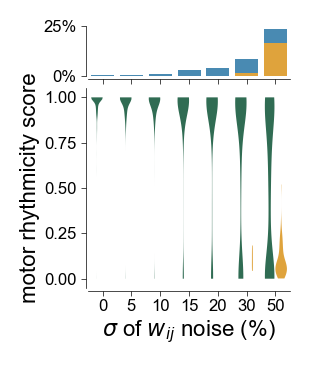

In [40]:
fig, ax = plt.subplots(2,1,height_ratios=[1,4],sharex=True,gridspec_kw={"hspace":0.1})
violinAx = ax[1]
barAx = ax[0]

simScore_plotShape = simScore.astype(float).melt(var_name="noiseStd",value_name="score")
nActive_plotShape = nActive.astype(float).melt(var_name="noiseStd",value_name="nActive")
simScore_plotShape["stable"] = nActive_plotShape["nActive"] <= 500
simScore_plotShape["active"] = nActive_plotShape["nActive"] >= 5

sns.violinplot(simScore_plotShape,x="noiseStd",y="score",hue="stable",hue_order=[True,False],ax=violinAx,
               edgecolor=None,inner=None,cut=0,alpha=1.0,palette=[mnColor,"#faaa21"],density_norm="count")
plt.legend().set_visible(False)
violinAx.set_ylabel("motor rhythmicity score")

pctNoMnsPerVal = (nMnsActive==0).sum()/nSims
pctOveractivePerVal = (nActive>500).sum()/nSims

sns.barplot(pctNoMnsPerVal+pctOveractivePerVal,label="no MNs",color="#388ec3ff",orient="v",ax=barAx,alpha=1.0)#,hatch="/////")
sns.barplot(pctOveractivePerVal,label="overactive",color="#faaa21ff",orient="v",ax=barAx,alpha=1.0)#,hatch='.....')
barAx.set_ylim([0,0.25])
barAx.set_yticklabels(["0%","25%"])
barAx.set_xlabel("")
barAx.set_xticklabels([int(s) for s in pctNoMnsPerVal.index.astype(float)*100])
plt.xlabel(r"$\sigma$ of $w_{ij}$ noise (%)",fontsize=8)

fig.set_figheight(1.7)
fig.set_figwidth(1.3)

sns.despine(offset=1)

# if not os.path.exists(figFolder):
#     os.makedirs(figFolder)
# plt.savefig(figFolder+f"/simScoreViolinAndStabiltyBars.svg",transparent=True)
plt.show()

In [38]:
mnColor

'#267655'

In [ ]:
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
nActive.to_csv(figFolder+"/nActive.csv")    
nMnsActive.to_csv(figFolder+"/nMnsActive.csv")
simScore.to_csv(figFolder+"/scores.csv")
mnFreq.to_csv(figFolder+"/frequencies.csv")
# for some reason I don't have permissio to save to the original data folder

## MANC DNg100 bilateral activation phase offsets

In [ ]:
simType = "DNg100_Stim"
simPath = simType+"/hyak/run_id=28123379"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/logs/run_config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])

figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

(1024, 4604, 2001)

### individual traces

684


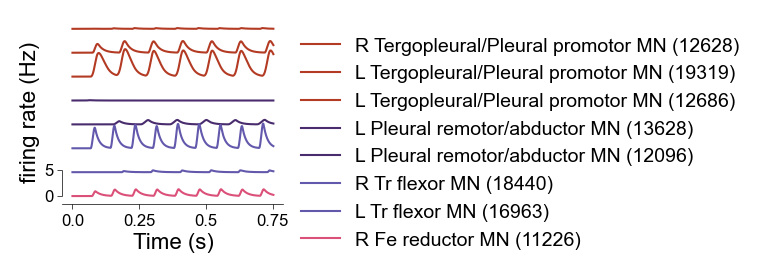

In [29]:
idx = np.random.randint(1000) 
spacer = 4.5
width = 3

R = Rs[idx]

plt.figure()
print(idx)
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer)# ,colorMapper=colorMapper)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,5,"k",linewidth=0.25)
plt.yticks([0,5])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.tick_params(labelsize=6)
# ax.grid(axis="x",color="lightgrey",linestyle="--")
ax.grid(False)
plt.ylabel("firing rate (Hz)",fontsize=8)
# plt.xlabel("Time (s)",fontsize=8)
fig = plt.gcf()
# fig.set_figheight(0.5*len(get_active_data(R[mnData.index],mnData)))
# fig.set_figheight(2.5)
# fig.set_figwidth(width)

fig.set_figwidth(1.426)
fig.set_figheight(1.2)




plt.show()

### phase plots

In [5]:
from scipy import signal

def wave_normalize(x):
    return x/np.mean(x)

In [30]:
wTable.loc[wTable["bodyId"].isin([12686,12096,12628])]

,Unnamed: 0,bodyId,type,class,subclass,hemilineage,size,predictedNt,predictedNtProb,ntAcetylcholineProb,ntGabaProb,ntGlutamateProb,somaSide,motor module,step contribution
713,713,12096,Pleural remotor/abductor MN,motor neuron,fl,TBD,1663258320,glutamate,0.450193,0.245552,0.210262,0.436701,LHS,coxa stance,stance
848,848,12628,Tergopleural/Pleural promotor MN,motor neuron,fl,TBD,2157027729,glutamate,0.432761,0.086071,0.150307,0.434847,RHS,coxa swing,swing
860,860,12686,Tergopleural/Pleural promotor MN,motor neuron,fl,TBD,2832306624,glutamate,0.373590,0.198403,0.288615,0.373630,LHS,coxa swing,swing


In [24]:
# tmpPro = pd.DataFrame(index=np.arange(400),columns=["pro phase","sample","pro","rem"])

sample = 0

phases = []
samples = []
activities = []
MNs = []

for simIdx in range(np.size(Rs,0)):
    
    if simIdx % 50 == 0:
        print(simIdx)

    R = Rs[simIdx]

    pro = R[860,300:]
    rem = R[713,300:]
    # pro1R = R[848,300:]
    prominence = 0.05
    pro1Peaks, peakProperties = signal.find_peaks(wave_normalize(pro),height=(None,None),prominence=prominence)
    rem1Peaks, peakProperties = signal.find_peaks(wave_normalize(rem),height=(None,None),prominence=prominence)

    for i in range(1,len(pro1Peaks)-1):

        phaseAxis = np.linspace(-2*np.pi,2*np.pi,400)

        phases += phaseAxis.tolist()
        activities += signal.resample(wave_normalize(pro[pro1Peaks[i-1]:pro1Peaks[i+1]]),400).tolist()
        MNs += ["pro"]*400
        samples += [sample]*400

        phases += phaseAxis.tolist()
        activities += signal.resample(wave_normalize(rem[pro1Peaks[i-1]:pro1Peaks[i+1]]),400).tolist()
        MNs += ["rem"]*400
        samples += [sample]*400

        sample+=1
        
allProAndRemPeaks = pd.DataFrame({"pro phase":phases,"sample":samples,"activity":activities,"MN":MNs})


0
50


/tmp/ipykernel_2782135/2587472190.py:4: RuntimeWarning: invalid value encountered in divide
  return x/np.mean(x)


100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


([<matplotlib.axis.YTick at 0x7f59963f2c10>,
 [Text(0, 0, '0'), Text(0, 3, '3')])

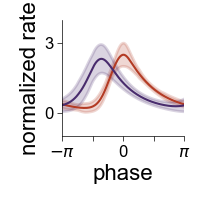

In [ ]:
plt.figure(figsize=(1.0,1.0))
sns.lineplot(allProAndRemPeaks,x="pro phase",y="activity",hue="MN",estimator="mean",errorbar="sd",palette=["#b33b24ff","#492c6dff"],
             legend=False,linewidth=0.75)

plt.xticks(np.linspace(-np.pi,np.pi+0.0001,5),[r"$-\pi$","","0","",r"$\pi$"])
plt.xlabel("phase")
plt.ylabel("normalized rate",fontsize=8)
plt.gca().tick_params(labelsize=6)
plt.tight_layout()
plt.xlim(-np.pi,np.pi+0.0001)
plt.ylim([-1,4])
plt.yticks([0,3])

plt.show()

In [33]:
sample = 0

phases = []
samples = []
activities = []
MNs = []

for simIdx in range(np.size(Rs,0)):
    
    if simIdx % 50 == 0:
        print(simIdx)

    R = Rs[simIdx]

    pro = R[860,300:]
    pro1R = R[848,300:]
    prominence = 0.05
    pro1Peaks, _ = signal.find_peaks(wave_normalize(pro),height=(None,None),prominence=prominence)
    pro1RPeaks, _ = signal.find_peaks(wave_normalize(pro1R),height=(None,None),prominence=prominence)

    for i in range(1,len(pro1Peaks)-1):

        phaseAxis = np.linspace(-2*np.pi,2*np.pi,400)

        phases += phaseAxis.tolist()
        activities += signal.resample(wave_normalize(pro[pro1Peaks[i-1]:pro1Peaks[i+1]]),400).tolist()
        MNs += ["pro L"]*400
        samples += [sample]*400

        phases += phaseAxis.tolist()
        activities += signal.resample(wave_normalize(pro1R[pro1Peaks[i-1]:pro1Peaks[i+1]]),400).tolist()
        MNs += ["pro R"]*400
        samples += [sample]*400

        sample+=1


allProLandRPeaks = pd.DataFrame({"pro L phase":phases,"sample":samples,"activity":activities,"MN":MNs})


0


/tmp/ipykernel_2782135/2587472190.py:4: RuntimeWarning: invalid value encountered in divide
  return x/np.mean(x)


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


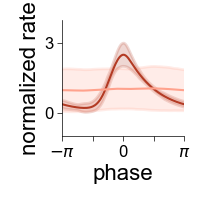

In [36]:
plt.figure(figsize=(1.0,1.0))
sns.lineplot(allProLandRPeaks,x="pro L phase",y="activity",hue="MN",estimator="mean",errorbar="sd",palette=["#b33b24ff","#ffa28dff"],
             legend=False,linewidth=0.75)
plt.xticks(np.linspace(-np.pi,np.pi+0.0001,5),[r"$-\pi$","","0","",r"$\pi$"])
plt.xlabel("phase")
plt.ylabel("normalized rate",fontsize=8)
plt.gca().tick_params(labelsize=6)
plt.tight_layout()
plt.xlim(-np.pi,np.pi+0.0001)
plt.ylim([-1,4])
plt.yticks([0,3])
plt.show()

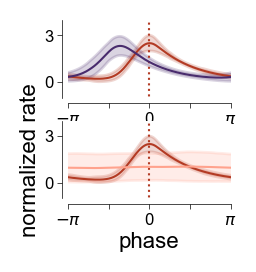

In [45]:
fig, ax = plt.subplots(2,1,sharex=False,sharey=True,)

ax[0].vlines(0,-2,4,colors=moduleColors["coxa swing"],linestyles=":",linewidth=0.75)
ax[1].vlines(0,-2,4,colors=moduleColors["coxa swing"],linestyles=":",linewidth=0.75)

sns.lineplot(allProAndRemPeaks,x="pro phase",y="activity",hue="MN",estimator="mean",errorbar="sd",palette=["#b33b24ff","#492c6dff"],
             legend=False,linewidth=0.75,ax=ax[0])
sns.lineplot(allProLandRPeaks,x="pro L phase",y="activity",hue="MN",estimator="mean",errorbar="sd",palette=["#b33b24ff","#ffa28dff"],
             legend=False,linewidth=0.75,ax=ax[1])

ax[0].set_xlabel("phase")
ax[1].set_xlabel("phase")
ax[0].set_ylabel("")
ax[1].set_ylabel("normalized rate")
ax[0].set_xlim(-np.pi,np.pi+0.0001)
ax[1].set_xlim(-np.pi,np.pi+0.0001)
ax[0].set_xticks(np.linspace(-np.pi,np.pi+0.0001,5),[r"$-\pi$","","0","",r"$\pi$"])
ax[1].set_xticks(np.linspace(-np.pi,np.pi+0.0001,5),[r"$-\pi$","","0","",r"$\pi$"])
plt.ylim([-1,4])
plt.yticks([0,3])

sns.despine(offset=2)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

fig.set_figheight(1.15)
fig.set_figwidth(1.05)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+"/coxaPhaseOffsets.svg",transparent=True)
plt.show()

## MANC DNg100 activation L $|I_\text{stim}|$ sweep

In [ ]:
simType = "DNg100_Stim"
simPath = simType+"/hyak/run_id=28914803"
folder = dataPath + simPath
overallParams = DictConfig(load_from_yaml(folder+"/multirun.yaml"))
wTable = pd.read_csv("../"+overallParams.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])

nSims = overallParams.experiment.n_replicates
nActive = pd.DataFrame(index=np.arange(nSims))
nMnsActive = pd.DataFrame(index=np.arange(nSims))
simScore = pd.DataFrame(index=np.arange(nSims))
mnFreq = pd.DataFrame(index=np.arange(nSims))

subfolders = []
for f in os.listdir(folder):
    if os.path.isdir(f"{folder}/{f}"):
        subfolders.append(f)

for subfolder in subfolders:
    print(f"Loading {subfolder}")
    Rs = sparse.load_npz(folder+f"/{subfolder}/ckpt/{simType}_Rs.npz").todense()
    dataset = 0
    Rs = Rs[dataset]
    params = DictConfig(load_from_yaml(folder+f"/{subfolder}/.hydra/config.yaml"))
    stimI = params.experiment.stimI[0]
    for i in range(nSims):
        # active neurons
        R = Rs[i]
        
        nActive.loc[i,stimI] = sum(np.max(R,1)>0.01)
        activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
        nMnsActive.loc[i,stimI] = np.sum(activeMnsMask)
        activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
        score, freq = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
        simScore.loc[i,stimI] = score
        mnFreq.loc[i,stimI] = freq

figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


Loading experiment.n_replicates=512,experiment.stimI=[180]
Loading experiment.n_replicates=512,experiment.stimI=[220]
Loading experiment.n_replicates=512,experiment.stimI=[300]
Loading experiment.n_replicates=512,experiment.stimI=[260]
Loading experiment.n_replicates=512,experiment.stimI=[340]


In [6]:
nActive = pd.DataFrame(index=np.arange(nSims))


for subfolder in subfolders:
    print(f"Loading {subfolder}")
    Rs = sparse.load_npz(folder+f"/{subfolder}/ckpt/{simType}_Rs.npz").todense()[0]
    params = DictConfig(load_from_yaml(folder+f"/{subfolder}/.hydra/config.yaml"))
    stimI = params.experiment.stimI[0]
    for i in range(nSims):
        # active neurons
        R = Rs[i]
        
        nActive.loc[i,stimI] = sum(np.max(R,1)>0.01)

Loading experiment.n_replicates=512,experiment.stimI=[180]
Loading experiment.n_replicates=512,experiment.stimI=[220]
Loading experiment.n_replicates=512,experiment.stimI=[300]
Loading experiment.n_replicates=512,experiment.stimI=[260]
Loading experiment.n_replicates=512,experiment.stimI=[340]


In [7]:
nActive.shape

(512, 5)

In [8]:
nActive = nActive.transpose().sort_index().transpose()
nMnsActive = nMnsActive.transpose().sort_index().transpose()
simScore = simScore.transpose().sort_index().transpose()
mnFreq = mnFreq.transpose().sort_index().transpose()

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
nActive.to_csv(figFolder+"/nActive.csv")    
nMnsActive.to_csv(figFolder+"/nMnsActive.csv")
simScore.to_csv(figFolder+"/scores.csv")
mnFreq.to_csv(figFolder+"/frequencies.csv")

([0, 1, 2, 3, 4],
 [Text(0, 0, '180'),
  Text(1, 0, '220'),
  Text(2, 0, '260'),
  Text(3, 0, '300'),
  Text(4, 0, '340')])

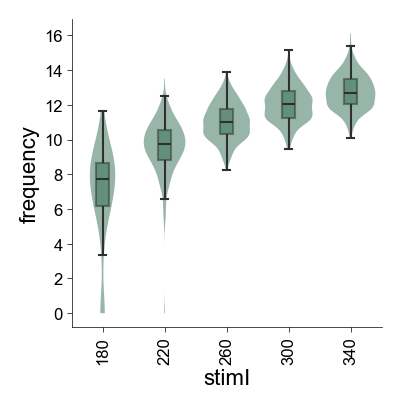

In [9]:
sns.violinplot((mnFreq[nMnsActive>0]/overallParams.sim.dt).astype(float).melt(var_name="stimI",value_name="frequency"),x="stimI",y="frequency",edgecolor=None,inner=None,cut=0,alpha=0.5,color=mnColor)
sns.boxplot((mnFreq[nMnsActive>0]/overallParams.sim.dt).astype(float).melt(var_name="stimI",value_name="frequency"),x="stimI",y="frequency",width=0.2,linewidth=0.75,fliersize=2**0.75,
            boxprops={"alpha":0.5,},showfliers=False,color=mnColor)
plt.xticks(rotation=90)

# plt.gcf().set_dpi(500)

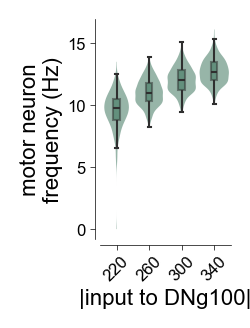

In [10]:
plt.figure(figsize=(0.84,1.426))
sns.violinplot((mnFreq[nMnsActive>0]/overallParams.sim.dt).iloc[:,1:].astype(float).melt(var_name="stimI",value_name="frequency"),x="stimI",y="frequency",edgecolor=None,inner=None,cut=0,alpha=0.5,color=mnColor,width=0.9)
sns.boxplot((mnFreq[nMnsActive>0]/overallParams.sim.dt).iloc[:,1:].astype(float).melt(var_name="stimI",value_name="frequency"),x="stimI",y="frequency",width=0.2,linewidth=0.75,fliersize=2**0.75,
            boxprops={"alpha":0.5,},showfliers=False,color=mnColor)
plt.gca().tick_params(axis='x', labelrotation=45)
sns.despine(offset=2)

plt.xlabel("|input to DNg100|")
plt.ylabel("motor neuron\nfrequency (Hz)")
# plt.gcf().set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnFreqViolin.svg",transparent=True)
plt.show()

In [11]:
mnFreq_plotShape = (mnFreq/overallParams.sim.dt).iloc[:,1:].astype(float).melt(var_name="stimI",value_name="frequency")
nMnsActive_plotShape = nMnsActive.iloc[:,1:].astype(float).melt(var_name="stimI",value_name="nMnsActive")

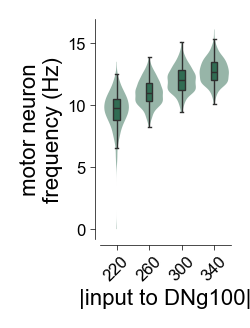

In [14]:
plt.figure(figsize=(0.84,1.426))
sns.violinplot(mnFreq_plotShape.loc[nMnsActive_plotShape["nMnsActive"]>0],x="stimI",y="frequency",edgecolor=None,inner=None,cut=0,alpha=0.5,color=mnColor,width=0.9)
sns.boxplot(mnFreq_plotShape.loc[nMnsActive_plotShape["nMnsActive"]>0],x="stimI",y="frequency",width=0.2,linewidth=0.5,fliersize=2**0.75,
            boxprops={"alpha":1.0,},showfliers=False,color=mnColor)
plt.gca().tick_params(axis='x', labelrotation=45)
sns.despine(offset=2)

plt.xlabel("|input to DNg100|")
plt.ylabel("motor neuron\nfrequency (Hz)")
# plt.gcf().set_dpi(500)
# plt.ylim([0,22])

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnFreqViolin_activeMnsOnly.svg",transparent=True)
plt.show()

In [13]:
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
nActive.to_csv(figFolder+"/nActive.csv")
nMnsActive.to_csv(figFolder+"/nMnsActive.csv")
simScore.to_csv(figFolder+"/scores.csv")
mnFreq.to_csv(figFolder+"/frequencies.csv")